In [1]:
from bresenham import bresenham
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from skimage import io

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

from ipywidgets import interact, interactive, fixed
from IPython.display import display, Image
import os
import math

In [2]:
sinogram = None

angleSpace = np.pi / 160 
angleRange = np.pi 
numberOfDetectors = 180

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def readImage(filepath):
    return rgb2gray(mpimg.imread(filepath))

def showImage(img):
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.show()

In [10]:
directoryName = input("Enter name of directory with images: ")
directoryName = directoryName + "/"

Enter name of directory with images: ./tomograf-zdjecia


In [11]:
image_variable = widgets.Combobox(
    value= None,
    placeholder='Choose picture',
    options=os.listdir(directoryName),
    description='File name:',
    ensure_option=True,
    disabled=False)

def imageFunction(x):
    image_variable.value = x
    display(Image(directoryName + str(image_variable.value)))
    
interact(imageFunction, x=os.listdir(directoryName))

interactive(children=(Dropdown(description='x', options=('CT_ScoutView-large.jpg', 'CT_ScoutView.jpg', 'Kolo.j…

<function __main__.imageFunction(x)>

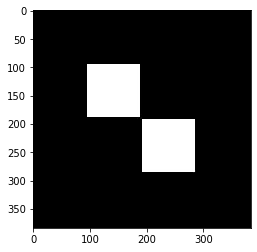

In [12]:
image = readImage(directoryName + str(image_variable.value))
showImage(image)

In [13]:
det_variable = widgets.IntSlider(
    min=90,
    max=720,
    step=90,
    description='Number of detector'
)

display(det_variable)

IntSlider(value=90, description='Number of detector', max=720, min=90, step=90)

In [14]:
numberOfDetectors = det_variable.value
numberOfDetectors

450

In [15]:
def circleCentre(image):
    coords = list(map(lambda x: x / 2, image.shape))
    radius = (coords[0] ** 2 + coords[1] ** 2) ** 0.5
    return {'x': coords[0], 'y': coords[1], 'r': radius}

circleCoords = circleCentre(image)
circleCoords


radius = circleCoords['r'] 

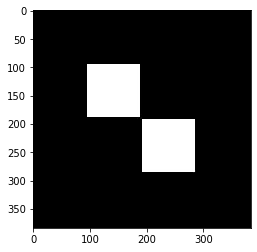

(384, 384)

In [16]:
#image = readImage('tomograf-zdjecia/Kolo.jpg')
#image = shepp_logan_phantom()
#image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
showImage(image)
image_x, image_y = image.shape[0], image.shape[1]
image.shape

In [17]:
def getPosition(alpha):
    x = circleCoords['x'] + circleCoords['r'] * np.cos(alpha)
    y = circleCoords['y'] + circleCoords['r'] * np.sin(alpha)
    return [int(x), int(y)]

def readValue(emi_x, emi_y, det_x, det_y):
    allPoints = list(bresenham(emi_x, emi_y, det_x, det_y))
    brightnessSum = 0
    pixelsNum = 0
    for point in allPoints:
        point_x = point[0]
        point_y = point[1]
        if (point_x > 0 and point_x < image_x and point_y > 0 and point_y < image_y):
            pixelsNum += 1
            brightnessSum += image[point_x][point_y]
    if pixelsNum > 0:
        val = brightnessSum / pixelsNum
        return val
    else:
        return 0

fullExtent = 2 * np.pi

numberOfEmitterPositions = int(fullExtent/ angleSpace)                         

def toSinogram():
    
    sin = np.zeros((numberOfEmitterPositions, numberOfDetectors))
    positionForSin = np.zeros((numberOfEmitterPositions, numberOfDetectors, 2, 2))
    
    for emitterAngle, i in zip(np.arange(0, fullExtent, angleSpace), range(numberOfEmitterPositions)):
        
        emitterPosition = getPosition(emitterAngle)
        
        emitterAtLeft = emitterAngle + np.pi - angleRange / 2
        emitterAtRight = emitterAngle + np.pi + angleRange / 2
        angleForDetector = angleRange / numberOfDetectors
        
        for detectorAngle, j in zip(np.arange(emitterAtLeft, emitterAtRight, angleForDetector), range(numberOfDetectors)):
            detectorPosition = getPosition(detectorAngle)
            sin[i][j] = readValue(emitterPosition[0], emitterPosition[1], detectorPosition[0], detectorPosition[1])
            positionForSin[i][j] = [detectorPosition, emitterPosition]
                               
    return sin, positionForSin
            
    
sinogram, positionForSin = toSinogram()

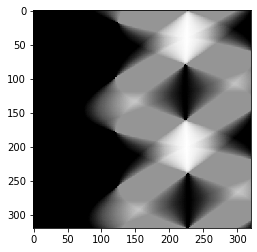

In [18]:
def imageAnimation(y):
    max_y = sinogram.shape[1]
    if y < max_y:
        tempSinogram = np.zeros((sinogram.shape[0],y))
        for y in range(y):
            for x in range(sinogram.shape[0]):
                tempSinogram[x][y] = int(255*sinogram[x][y])
    else:
        pass
    showImage(tempSinogram)
    
imageAnimation(320)

In [19]:
y = widgets.IntSlider(min=1, max=numberOfDetectors - 1, description='y')

out = widgets.interactive_output(imageAnimation, {'y': y})

widgets.HBox([widgets.VBox([y]), out])

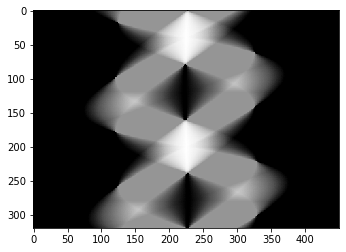

In [20]:
showImage(sinogram)

In [21]:
resultImage = np.zeros(image.shape)
countForPoints = np.zeros(image.shape)

def addLineToResult(emi_x, emi_y, det_x, det_y, value):
    
    allPoints = list(bresenham(int(emi_x), int(emi_y), int(det_x), int(det_y)))
    for point in allPoints:
        point_x = point[0]
        point_y = point[1]
        if 0 <= point_x and image_x > point_x and 0 <= point_y and image_y > point_y:
            countForPoints[point_x][point_y] += 1
            resultImage[point_x][point_y] += value
      
    return countForPoints, resultImage

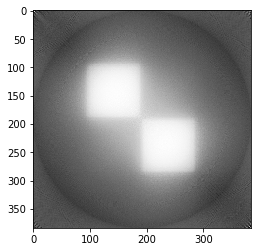

In [22]:
def sinogramToResultImage(angleSpace, angleRange):   
    for i in range(sinogram.shape[0]):
        for j in range(sinogram.shape[1]):
            emitterPosition = positionForSin[i][j][1]
            detectorPosition = positionForSin[i][j][0]
            countForPoints, resultImage = addLineToResult(emitterPosition[0], emitterPosition[1], detectorPosition[0], detectorPosition[1], sinogram[i][j]) 
    return resultImage
   
def divideByCountForPoints(resultImage):
    for i in range(resultImage.shape[0]):
        for j in range(resultImage.shape[1]):
            if countForPoints[i][j] != 0:
                resultImage[i][j] /= countForPoints[i][j]
            else:
                resultImage[i][j] = 0
                
    return resultImage


resultImage = sinogramToResultImage(angleSpace, angleRange)
resultImage = divideByCountForPoints(resultImage)
showImage(resultImage)

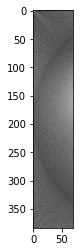

In [23]:
def resultImageAnimation(z):
    max_y = resultImage.shape[0]
    if z < max_y:
        tempSinogram = np.zeros((resultImage.shape[1],z))
        for y in range(z):
            for x in range(resultImage.shape[1]):
                tempSinogram[x][y] = int(255*resultImage[x][y])
    else:
        pass
    showImage(tempSinogram)
    
resultImageAnimation(70)

In [24]:
z = widgets.IntSlider(min=1, max=resultImage.shape[0] - 1, description='z')

out = widgets.interactive_output(resultImageAnimation, {'z': z})

widgets.HBox([widgets.VBox([z]), out])

# Dla sprawdzenia - przy użyciu gotowych funkcji

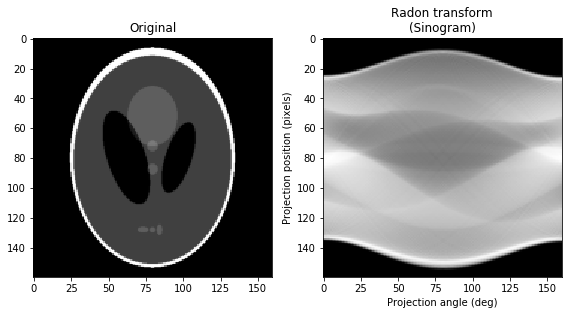

In [105]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
#image = readImage('tomograf-zdjecia/Kolo.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
"""ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')"""
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()